In [66]:
# Import datasets

import pandas as pd

df_all_agg = pd.read_csv("df_all_agg.csv", sep = ',')
df_all_cleaned = pd.read_csv("df_all_cleaned.csv", sep = ',')

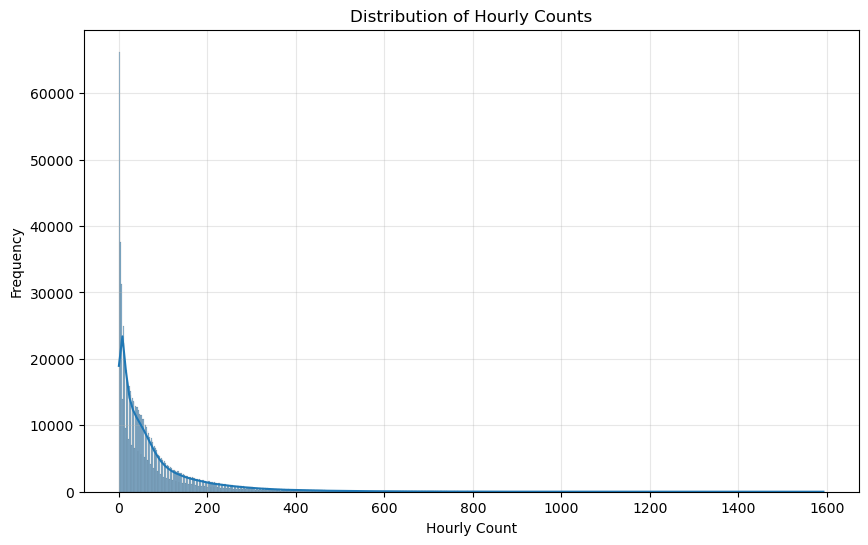

In [70]:
# Histogram of hourly counts

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot histogram 
sns.histplot(data=df_all_cleaned, 
            x='Hourly Count', 
            kde=True)

plt.title('Distribution of Hourly Counts')
plt.xlabel('Hourly Count')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

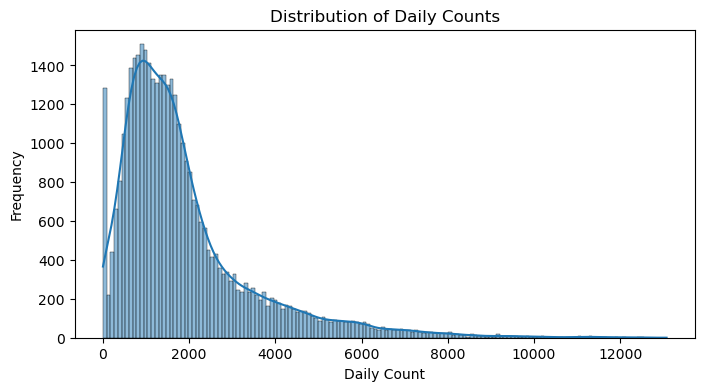

In [72]:
# Histogram of daily counts

# Create figure
plt.figure(figsize=(8, 4))

# Plot histogram
sns.histplot(data=df_all_agg, 
            x='Daily Count', 
            kde=True)

plt.title('Distribution of Daily Counts')
plt.xlabel('Daily Count')
plt.ylabel('Frequency')
plt.show()

In [74]:
!pip install hdbscan

In [76]:
# First HBDSCAN - min_samples=5, min_cluster_size=5

import pandas as pd
import numpy as np
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Prepare data
def prepare_data_for_clustering(df):
    # Calculate the features we want to use for clustering
    features = df.groupby('Counter Name').agg({
        'Daily Count': ['mean', 'std'], 
        'Arrondisement': 'first'
    }).reset_index()
    
    # Flatten the column names
    features.columns = ['Counter_Name', 'Mean_Count', 'Std_Count', 'Arrondisement']
    
    # Scale the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features[['Mean_Count', 'Std_Count']])
    
    return features, features_scaled

# Implement HDBSCAN
def apply_hdbscan(features_scaled, min_samples=5):
    clusterer = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=5)
    cluster_labels = clusterer.fit_predict(features_scaled)
    
    return clusterer, cluster_labels

# Get features and apply clustering
features, features_scaled = prepare_data_for_clustering(df_all_agg)
clusterer, cluster_labels = apply_hdbscan(features_scaled)

# Add cluster labels to features df
features['Cluster'] = cluster_labels
features['Cluster_Probability'] = clusterer.probabilities_

# Calculate silhouette score (ignoring noise points labeled as -1)
mask = features['Cluster'] != -1
silhouette_avg = silhouette_score(features_scaled[mask], features['Cluster'][mask])
print(f"Silhouette Score: {silhouette_avg}")

# Average cluster probability for non-noise points
avg_prob = features[features['Cluster'] != -1]['Cluster_Probability'].mean()
print(f"Average cluster probability: {avg_prob}")

# Print cluster info
print("\nClustering Results:")
print(f"Number of clusters found: {len(set(features['Cluster'].unique())) - (1 if -1 in features['Cluster'].unique() else 0)}")
print("\nPoints per cluster:")
print(features['Cluster'].value_counts())

Silhouette Score: 0.5276710240473018
Average cluster probability: 0.8765323783751591

Clustering Results:
Number of clusters found: 3

Points per cluster:
Cluster
-1    49
 2    30
 0    12
 1    10
Name: count, dtype: int64


In [82]:
# Make a function to try different parameters
def try_parameters(features_scaled, min_samples_list=[3, 5, 7, 10], min_cluster_sizes=[3, 5, 7, 10]):
    results = []
    
    for min_samples in min_samples_list:
        for min_cluster_size in min_cluster_sizes:
            # Skip invalid combinations
            if min_cluster_size < min_samples:
                continue
                
            clusterer = hdbscan.HDBSCAN(
                min_samples=min_samples,
                min_cluster_size=min_cluster_size
            )
            
            cluster_labels = clusterer.fit_predict(features_scaled)
            
            # Only calculate silhouette if there's more than one cluster and non-noise points
            mask = cluster_labels != -1
            n_clusters = len(set(cluster_labels[mask]))
            
            if n_clusters > 1 and sum(mask) > 1:
                sil_score = silhouette_score(features_scaled[mask], cluster_labels[mask])
            else:
                sil_score = np.nan
                
            results.append({
                'min_samples': min_samples,
                'min_cluster_size': min_cluster_size,
                'n_clusters': n_clusters,
                'n_noise': sum(cluster_labels == -1),
                'silhouette': sil_score,
                'avg_prob': clusterer.probabilities_[cluster_labels != -1].mean() if sum(mask) > 0 else np.nan
            })
    
    return pd.DataFrame(results)

# Run parameter search
features, features_scaled = prepare_data_for_clustering(df_all_agg)
results_df = try_parameters(features_scaled)

# Sort by silhouette score
print("\nTop 5 parameter combinations by silhouette score:")
print(results_df.sort_values('silhouette', ascending=False).head().to_string())

# Sort by average probability
print("\nTop 5 parameter combinations by cluster probability:")
print(results_df.sort_values('avg_prob', ascending=False).head().to_string())


Top 5 parameter combinations by silhouette score:
   min_samples  min_cluster_size  n_clusters  n_noise  silhouette  avg_prob
9           10                10           2       72    0.675656  0.980544
7            7                 7           3       55    0.570232  0.926494
8            7                10           2       63    0.568920  0.941686
4            5                 5           3       49    0.527671  0.876532
5            5                 7           3       49    0.527671  0.882562

Top 5 parameter combinations by cluster probability:
   min_samples  min_cluster_size  n_clusters  n_noise  silhouette  avg_prob
9           10                10           2       72    0.675656  0.980544
8            7                10           2       63    0.568920  0.941686
6            5                10           3       49    0.527671  0.936022
2            3                 7           3       52    0.504992  0.927160
7            7                 7           3       55    0.

In [86]:
def apply_hdbscan_and_analyze(features, features_scaled, min_samples, min_cluster_size):
    clusterer = hdbscan.HDBSCAN(
        min_samples=min_samples,
        min_cluster_size=min_cluster_size
    )
    
    cluster_labels = clusterer.fit_predict(features_scaled)
    
    # Add results to features df
    results = features.copy()
    results['Cluster'] = cluster_labels
    results['Cluster_Probability'] = clusterer.probabilities_
    
    # Calculate metrics
    mask = cluster_labels != -1
    silhouette_avg = silhouette_score(features_scaled[mask], cluster_labels[mask])
    avg_prob = clusterer.probabilities_[cluster_labels != -1].mean()
    
    print(f"\nResults for min_samples={min_samples}, min_cluster_size={min_cluster_size}:")
    print(f"Silhouette Score: {silhouette_avg:.3f}")
    print(f"Average Probability: {avg_prob:.3f}")
    print(f"Number of clusters: {len(set(cluster_labels[mask]))}")
    print(f"Number of noise points: {sum(cluster_labels == -1)}")
    print("\nPoints per cluster:")
    print(results['Cluster'].value_counts())
    
    return results

# Prepare data
features, features_scaled = prepare_data_for_clustering(df_all_agg)

# Try both parameter combinations
# 1. Better statistical quality
results_optimal = apply_hdbscan_and_analyze(features, features_scaled, min_samples=10, min_cluster_size=10)

# 2. One with 3 Clusters
results_granular = apply_hdbscan_and_analyze(features, features_scaled, min_samples=7, min_cluster_size=7)



Results for min_samples=10, min_cluster_size=10:
Silhouette Score: 0.676
Average Probability: 0.981
Number of clusters: 2
Number of noise points: 72

Points per cluster:
Cluster
-1    72
 0    17
 1    12
Name: count, dtype: int64

Results for min_samples=7, min_cluster_size=7:
Silhouette Score: 0.570
Average Probability: 0.926
Number of clusters: 3
Number of noise points: 55

Points per cluster:
Cluster
-1    55
 2    26
 1    12
 0     8
Name: count, dtype: int64


C:\Users\Asus\AppData\Local\Temp\ipykernel_53284\3993655607.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap('tab10')(label)


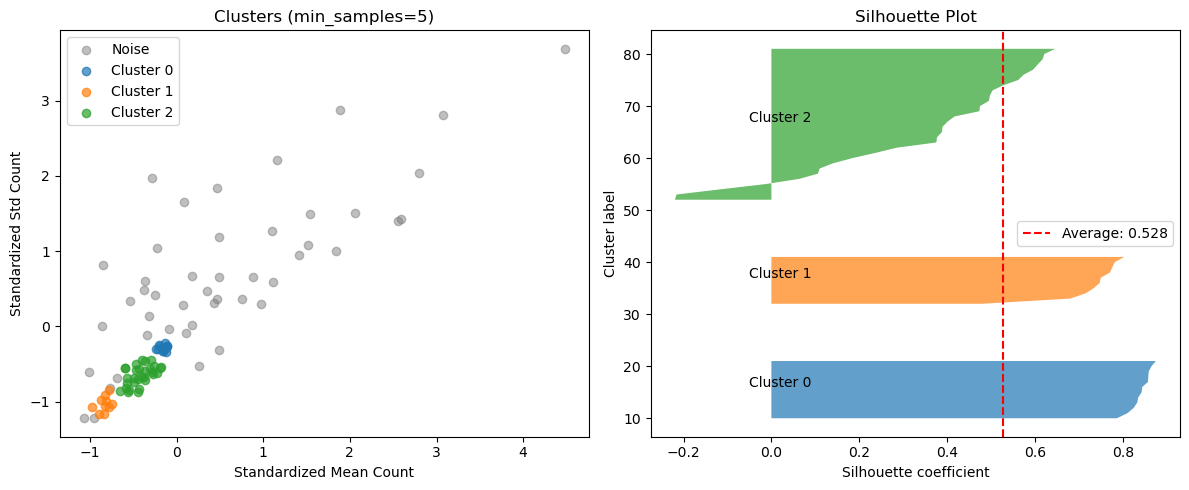

C:\Users\Asus\AppData\Local\Temp\ipykernel_53284\3993655607.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap('tab10')(label)


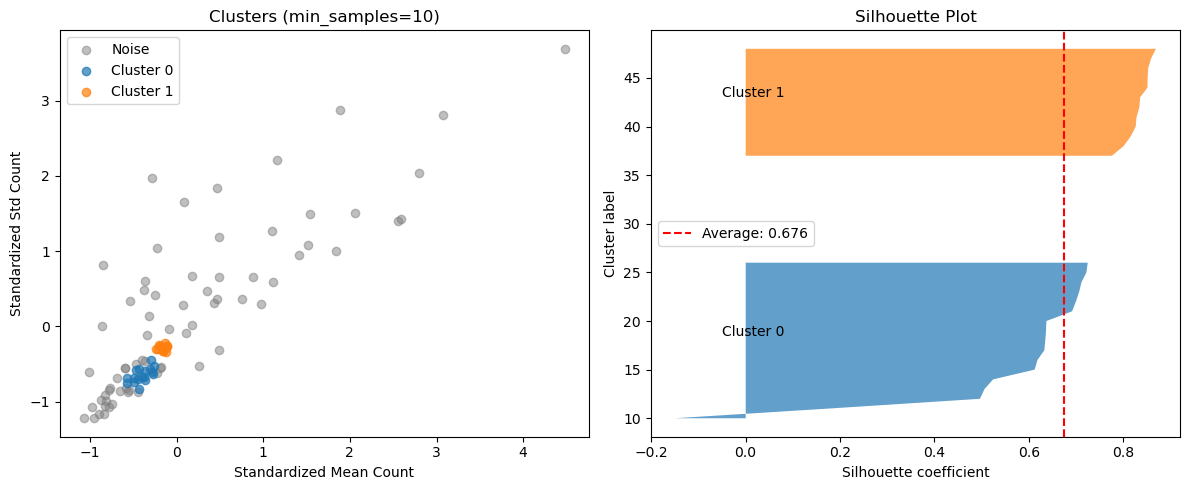

C:\Users\Asus\AppData\Local\Temp\ipykernel_53284\3993655607.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap('tab10')(label)


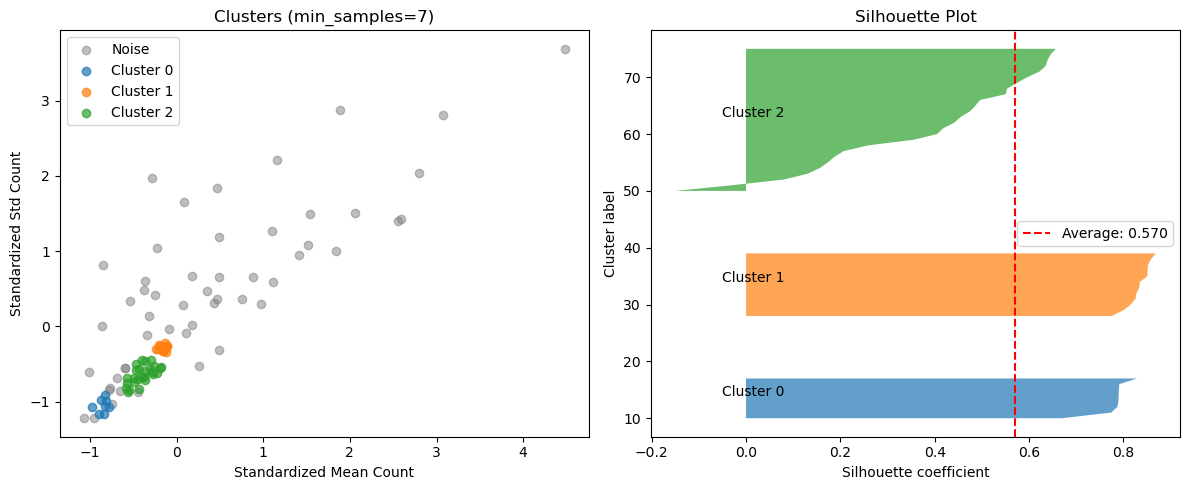

In [92]:
#Visualization of the clusters and Silhouette plots for all three models so far

def plot_clustering_results(features_scaled, cluster_labels, min_samples, min_cluster_size):
    # Create scatter plot
    plt.figure(figsize=(12, 5))
    
    # Subplot 1: Scatter plot of clusters
    plt.subplot(121)
    
    # Plot noise points
    noise_mask = cluster_labels == -1
    plt.scatter(features_scaled[noise_mask, 0], features_scaled[noise_mask, 1], 
                c='gray', label='Noise', alpha=0.5)
    
    # Plot clusters
    for label in set(cluster_labels[cluster_labels != -1]):
        mask = cluster_labels == label
        plt.scatter(features_scaled[mask, 0], features_scaled[mask, 1], 
                   label=f'Cluster {label}', alpha=0.7)
    
    plt.title(f'Clusters (min_samples={min_samples})')
    plt.xlabel('Standardized Mean Count')
    plt.ylabel('Standardized Std Count')
    plt.legend()
    
    # Subplot 2: Silhouette plot
    plt.subplot(122)
    
    # Calculate silhouette scores for non-noise points
    non_noise_mask = cluster_labels != -1
    silhouette_vals = silhouette_samples(features_scaled[non_noise_mask], 
                                       cluster_labels[non_noise_mask])
    
    y_lower = 10
    for label in sorted(set(cluster_labels[cluster_labels != -1])):
        cluster_silhouette_vals = silhouette_vals[cluster_labels[non_noise_mask] == label]
        cluster_silhouette_vals.sort()
        
        size_cluster = len(cluster_silhouette_vals)
        y_upper = y_lower + size_cluster
        
        color = plt.cm.get_cmap('tab10')(label)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                         facecolor=color, alpha=0.7)
        
        plt.text(-0.05, y_lower + 0.5 * size_cluster, f'Cluster {label}')
        y_lower = y_upper + 10
        
    plt.title('Silhouette Plot')
    plt.xlabel('Silhouette coefficient')
    plt.ylabel('Cluster label')
    plt.axvline(x=silhouette_vals.mean(), color='red', linestyle='--', 
                label=f'Average: {silhouette_vals.mean():.3f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Get features and apply HDBSCAN for all variants
features, features_scaled = prepare_data_for_clustering(df_all_agg)

# Variant 1: min_samples=5
clusterer_5 = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=5)
labels_5 = clusterer_5.fit_predict(features_scaled)
plot_clustering_results(features_scaled, labels_5, 5, 5)

# Variant 2: min_samples=10
clusterer_10 = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=10)
labels_10 = clusterer_10.fit_predict(features_scaled)
plot_clustering_results(features_scaled, labels_10, 10, 10)

# Variant 3: min_samples=7
clusterer_7 = hdbscan.HDBSCAN(min_samples=7, min_cluster_size=7)
labels_7 = clusterer_7.fit_predict(features_scaled)
plot_clustering_results(features_scaled, labels_7, 7, 7)

In [94]:
### Not used in report ###

def prepare_data_for_clustering_with_weekends(df):
    # Convert Date to datetime if it's not already
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Calculate features for each counter
    features = df.groupby('Counter Name').agg({
        'Daily Count': 'mean',  # Overall mean
    }).reset_index()
    
    # Add weekend/weekday means
    weekend_means = df[df['Date'].dt.weekday >= 5].groupby('Counter Name')['Daily Count'].mean()
    weekday_means = df[df['Date'].dt.weekday < 5].groupby('Counter Name')['Daily Count'].mean()
    
    features['Weekend_Mean'] = features['Counter Name'].map(weekend_means)
    features['Weekday_Mean'] = features['Counter Name'].map(weekday_means)
    
    # Add standard deviations if desired
    features['Count_Std'] = df.groupby('Counter Name')['Daily Count'].std().values
    
    # Scale the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features[['Daily Count', 'Weekend_Mean', 'Weekday_Mean', 'Count_Std']])
    
    return features, features_scaled

# Apply HDBSCAN with the new features
def apply_hdbscan_and_analyze(features, features_scaled, min_samples=7, min_cluster_size=7):
    clusterer = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)
    cluster_labels = clusterer.fit_predict(features_scaled)
    
    # Add results to features DataFrame
    results = features.copy()
    results['Cluster'] = cluster_labels
    results['Cluster_Probability'] = clusterer.probabilities_
    
    return results, clusterer

# Run the analysis
features, features_scaled = prepare_data_for_clustering_with_weekends(df_all_agg)
results, clusterer = apply_hdbscan_and_analyze(features, features_scaled)

# Print results
print("Clustering Results:")
print("\nPoints per cluster:")
print(results['Cluster'].value_counts())

# Show cluster characteristics
print("\nCluster Characteristics:")
for cluster in sorted(results['Cluster'].unique()):
    cluster_data = results[results['Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"Number of counters: {len(cluster_data)}")
    print(f"Average daily count: {cluster_data['Daily Count'].mean():.2f}")
    print(f"Average weekend count: {cluster_data['Weekend_Mean'].mean():.2f}")
    print(f"Average weekday count: {cluster_data['Weekday_Mean'].mean():.2f}")

Clustering Results:

Points per cluster:
Cluster
-1    66
 1    24
 0    11
Name: count, dtype: int64

Cluster Characteristics:

Cluster -1:
Number of counters: 66
Average daily count: 2110.42
Average weekend count: 1606.82
Average weekday count: 2396.08

Cluster 0:
Number of counters: 11
Average daily count: 1615.07
Average weekend count: 1037.43
Average weekday count: 1848.54

Cluster 1:
Number of counters: 24
Average daily count: 1191.50
Average weekend count: 813.47
Average weekday count: 1344.23
